In [1]:
import sys
sys.path.insert(0, '../../../network')

In [2]:
import logging
import argparse
import numpy as np
from network import Population, RateNetwork
from learning import ReachingTask
from transfer_functions import ErrorFunction
from connectivity import SparseConnectivity, LinearSynapse, ThresholdPlasticityRule
from sequences import GaussianSequence
import matplotlib.pyplot as plt
import seaborn as sns
logging.basicConfig(level=logging.INFO)

In [3]:
phi = ErrorFunction(mu=0.22, sigma=0.1).phi
ctx = Population(N=1000, tau=1e-2, phi=phi, name='ctx')
bg = Population(N=1000, tau=1e-2, phi=phi, name='bg')
plasticity = ThresholdPlasticityRule(x_f=0.5, q_f=0.8) 

S, P = 1, 3
sequences_ctx = [GaussianSequence(P,ctx.size, seed=5) for i in range(S)]
patterns_ctx = np.stack([s.inputs for s in sequences_ctx])
sequences_bg = [GaussianSequence(P,ctx.size, seed=27) for i in range(S)]
patterns_bg = np.stack([s.inputs for s in sequences_bg])

J_cc = SparseConnectivity(source=ctx, target=ctx, p=0.05)
synapse_cc = LinearSynapse(J_cc.K, A=5)
J_cc.store_attractors(patterns_ctx[0], patterns_ctx[0], synapse_cc.h_EE, 
                      plasticity.f, plasticity.g)
J_bb = SparseConnectivity(source=bg, target=bg, p=0.05)
synapse_bb = LinearSynapse(J_bb.K, A=5)
J_bb.store_attractors(patterns_bg[0], patterns_bg[0], synapse_bb.h_EE, 
                      plasticity.f, plasticity.g)
J_cb  = SparseConnectivity(source=bg, target=ctx, p=0.05)
synapse_cb = LinearSynapse(J_cb.K, A=1)
J_cb.store_attractors(patterns_bg[0], patterns_ctx[0], synapse_cb.h_EE, 
                      plasticity.f, plasticity.g)

J_bc = SparseConnectivity(source=ctx, target=bg, p=0.05)
synapse_bc = LinearSynapse(J_bc.K, A=0)
J_bc.store_sequences(patterns_ctx, patterns_bg, synapse_bc.h_EE, plasticity.f, plasticity.g)
net_ctx = RateNetwork(ctx, c_EE=J_cc, c_IE=J_bc, formulation=4)
net_bg = RateNetwork(bg, c_II=J_bb, c_EI=J_cb, formulation=4)

INFO:connectivity:Building connections from ctx to ctx
INFO:connectivity:Storing attractors
100%|████████████████████████████████████| 1000/1000 [00:00<00:00, 18676.96it/s]
INFO:connectivity:Building connections from bg to bg
INFO:connectivity:Storing attractors
100%|████████████████████████████████████| 1000/1000 [00:00<00:00, 20365.84it/s]
INFO:connectivity:Building connections from bg to ctx
INFO:connectivity:Storing attractors
100%|████████████████████████████████████| 1000/1000 [00:00<00:00, 23080.25it/s]
INFO:connectivity:Building connections from ctx to bg
INFO:connectivity:Storing sequences
100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.10it/s]
INFO:connectivity:Applying synaptic transfer function
INFO:connectivity:Building sparse matrix


In [4]:
# init_input_ctx = np.random.RandomState().normal(0,1,size=patterns_ctx[0][0].shape)
# init_input_bg = np.random.RandomState().normal(0,1,size=patterns_bg[0][0].shape)
init_input_ctx = patterns_ctx[0][0]
init_input_bg = patterns_bg[0][0]
T=10
mouse = ReachingTask(3, alpha=0.5)
net_ctx.simulate_learning(mouse, net_bg, T, init_input_ctx, init_input_bg, 
                          phi(patterns_ctx[0]), phi(patterns_bg[0]), plasticity)

INFO:network:Integrating network dynamics
  5%|█▊                                      | 458/9999 [00:21<06:51, 23.16it/s]

aim-->lick


  9%|███▌                                    | 905/9999 [00:40<06:28, 23.40it/s]

lick-->lick


 14%|█████▎                                 | 1358/9999 [01:00<06:10, 23.33it/s]

lick-->lick


 18%|███████                                | 1799/9999 [01:18<05:53, 23.19it/s]

lick-->reach


 23%|████████▊                              | 2261/9999 [01:38<05:33, 23.23it/s]

reach-->aim


 27%|██████████▌                            | 2708/9999 [01:57<05:10, 23.52it/s]

aim-->lick


 32%|████████████▍                          | 3182/9999 [02:17<04:49, 23.52it/s]

lick-->lick


 36%|██████████████▏                        | 3635/9999 [02:36<04:31, 23.47it/s]

lick-->aim


 41%|███████████████▉                       | 4085/9999 [02:56<04:27, 22.12it/s]

aim-->reach


 45%|█████████████████▋                     | 4529/9999 [03:15<03:55, 23.23it/s]

reach-->lick


 46%|█████████████████▉                     | 4604/9999 [03:18<04:05, 21.96it/s]

Mouse received reward
-1 2


 50%|███████████████████▍                   | 4975/9999 [03:34<03:32, 23.59it/s]

lick-->lick


 54%|█████████████████████                  | 5414/9999 [03:54<03:19, 22.94it/s]

lick-->lick


 58%|██████████████████████▊                | 5849/9999 [04:13<02:56, 23.47it/s]

lick-->aim


 63%|████████████████████████▌              | 6293/9999 [04:32<02:42, 22.79it/s]

aim-->lick


 67%|██████████████████████████▎            | 6740/9999 [04:52<02:20, 23.27it/s]

lick-->reach


 72%|████████████████████████████           | 7193/9999 [05:11<02:00, 23.33it/s]

reach-->reach


 76%|█████████████████████████████▋         | 7622/9999 [05:29<01:41, 23.44it/s]

reach-->aim


 81%|███████████████████████████████▍       | 8060/9999 [05:48<01:21, 23.65it/s]

aim-->lick


 85%|█████████████████████████████████▏     | 8501/9999 [06:07<01:04, 23.40it/s]

lick-->reach


 89%|██████████████████████████████████▉    | 8947/9999 [06:27<00:45, 23.33it/s]

reach-->lick


 94%|████████████████████████████████████▋  | 9412/9999 [06:47<00:26, 22.41it/s]

lick-->aim


 99%|██████████████████████████████████████▍| 9865/9999 [07:06<00:05, 22.85it/s]

aim-->lick


100%|██████████████████████████████████████▉| 9997/9999 [07:12<00:00, 23.64it/s]

In [5]:
overlaps_ctx = sequences_ctx[0].overlaps(net_ctx, ctx, phi=phi)
# correlations_ctx = sequences_ctx[0].overlaps(net_ctx, ctx, phi=phi, correlation=True)
overlaps_bg = sequences_bg[0].overlaps(net_bg, bg, phi=phi)
# correlations_bg = sequences_bg[0].overlaps(net_bg, bg, phi=phi, correlation=True)

INFO:sequences:Computing overlaps

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 251.90it/s]
INFO:sequences:Computing overlaps

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 321.13it/s]


In [6]:
sns.set_style('dark') 
plt.rcParams["font.family"] = "arial"
colors = sns.color_palette('deep')

100%|███████████████████████████████████████| 9999/9999 [07:13<00:00, 23.07it/s]


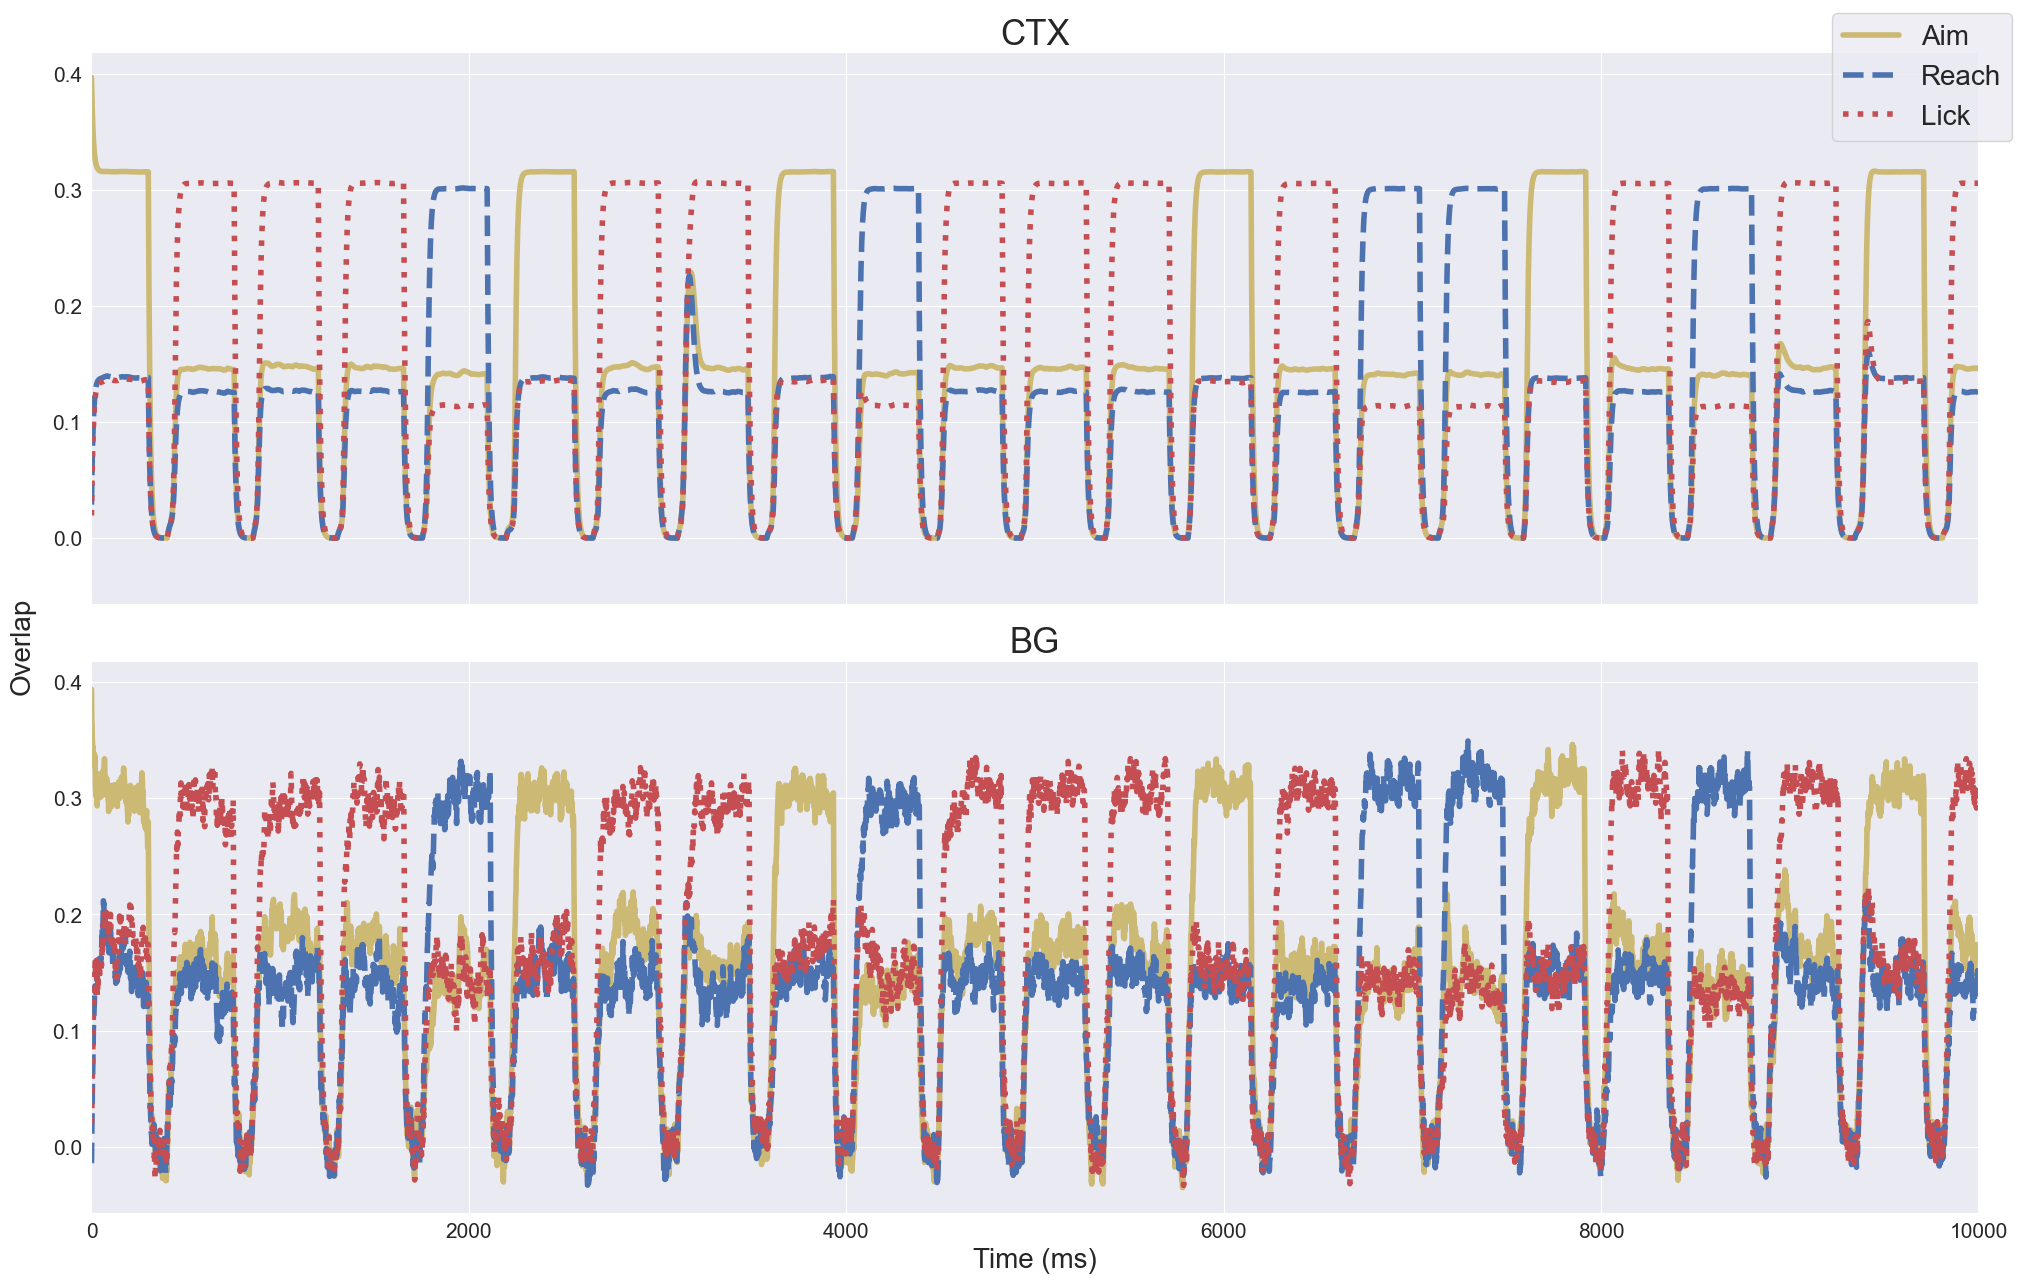

In [7]:
fig, axes = plt.subplots(2,1, sharex=True, sharey=True, tight_layout=True, figsize=(20,13))
axes[0].plot(overlaps_ctx[0], linestyle='solid', linewidth=4, color=colors[8])
axes[0].plot(overlaps_ctx[1], linestyle='dashed', linewidth=4, color=colors[0])
axes[0].plot(overlaps_ctx[2], linestyle='dotted', linewidth=4, color=colors[3])
axes[0].set_yticks([0.0, 0.1, 0.2, 0.3, 0.4])
axes[0].set_title("CTX", fontsize=25)
axes[1].plot(overlaps_bg[0], linestyle='solid', linewidth=4, color=colors[8])
axes[1].plot(overlaps_bg[1], linestyle='dashed', linewidth=4, color=colors[0])
axes[1].plot(overlaps_bg[2], linestyle='dotted', linewidth=4, color=colors[3])
axes[1].set_yticks([0.0, 0.1, 0.2, 0.3, 0.4])
axes[1].set_title("BG", fontsize=25)
axes[1].set_xlabel('Time (ms)', fontsize=20)
fig.text(-0.01, 0.5, 'Overlap', va='center', rotation='vertical', fontsize=20)
plt.setp(axes, xlim=(0, 10000))
plt.figlegend(labels=['Aim', 'Reach', 'Lick'], fontsize=20)
plt.show()
